<hr/>

# Foundations of Reinforcement Learning

<hr/>

<h1><font color="darkblue">Lab 4: Monte Carlo Method  </font></h1>





##  Content
1. Monte Carlo Method


Import Gym and other necessary libraries

In [1]:
pip install gym

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import gym
from IPython import display
import random

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 1. Monte Carlo Method  (CartPole-v1 environment)

### 1.1 CartPole Introduction

We now apply Monte Carlo Method for CartPole problem. 


1. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. 

0. The system is controlled by applying a force of +1 or -1 to the cart. 

0. The pendulum starts up, and the goal is to prevent it from falling over. 

0. A reward of +1 is provided for every timestep that the pole remains up. 

0. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

0. For more info (See [SOURCE ON GITHUB](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)).

The following examples show the basic usage of this testing environment: 



### 1.1.1 Episode initialization and Initial Value

In [3]:
env = gym.make('CartPole-v1')
observation = env.reset() ##Initial an episode

print("Inital observation is {}".format(observation))

print("\nThis means the cart current position is {}".format(observation[0][0]), end = '')
print(" with velocity {},".format(observation[0][1]))

print("and the pole current angular position is {}".format(observation[0][2]), end = '')
print(" with angular velocity {},".format(observation[0][3]))


Inital observation is (array([ 0.01181055, -0.01923591, -0.01917216,  0.02427869], dtype=float32), {})

This means the cart current position is 0.011810552328824997 with velocity -0.019235914573073387,
and the pole current angular position is -0.01917216368019581 with angular velocity 0.024278689175844193,


### 1.1.2 Take actions


Use env.step(action) to take an action

action is an integer from 0 to 1

0: "Left"; 1: "Right"

In [4]:
print("Current observation is {}".format(observation))

action = 0 #go left
observation, reward, done, info,info1 = env.step(action) # simulate one step

print("\nNew observation is {}".format(observation))
print("\n Reward is {}".format(reward))
print("Step reward is {}".format(reward))
print("Did episode just ends? -{}".format(done)) # episode ends when 3.1(6) happens



Current observation is (array([ 0.01181055, -0.01923591, -0.01917216,  0.02427869], dtype=float32), {})

New observation is [ 0.01142583 -0.21407774 -0.01868659  0.31085145]

 Reward is 1.0
Step reward is 1.0
Did episode just ends? -False


C:\Users\rprikhodko\Anaconda4\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


### 1.1.3 Simulate multiple episodes

(You may uncomment those lines to see an animation. However, it will not work for JupyterHub since the animation requires GL instead of webGL. If you have Jupyter notebook localy on your computer, this version of code will work through a virtual frame.)

In [5]:
env = gym.make('CartPole-v1')
observation = env.reset()
total_reward = 0
ep_num = 0

for _ in range(1000):
 
    action = env.action_space.sample()     # this takes random actions
    observation, reward, done, info,info1 = env.step(action) 
       
    total_reward += reward
    


    if done:                               # episode just ends
        observation = env.reset()          # reset episode
        ep_num += 1

print("Average reward per episode is {}".format(total_reward/ep_num))
env.close()


Average reward per episode is 24.390243902439025


### 1.1.4 States simplification 

For convenience, we consider only cart position and pole angular position, (i.e. state dimension = 2).

Note that the observed cart position $P \in [-4.8, 4.8]$ and pole angular position $\theta \in [-0.418, 0.418]$ for all times. Then, we could evenly devide those two intervals to from a finite number of states.

In [6]:
def find_state_idx(ob,ls0,ls1):
    pos_diff = ob[0] +4.8
    a_pos_diff = ob[2] + 0.418
    
    step_size_1 = 4.8*2/(ls0-1)
    step_size_2 = 0.418*2/(ls1-1)
    
    
    d_1 = np.round(pos_diff/step_size_1)
    d_3 = np.round(a_pos_diff/step_size_2)
     
    return [d_1,d_3]


ls_cart = 100 #devide the position of cart into 100 states
ls_pole = 100 #devide the angular position of pole into 100 states

# Threre are 100 * 100 = 10000 different states in total

observation = env.reset()
state_idx = find_state_idx(observation[0],ls_cart,ls_pole)

print("\nThe cart current position is {}".format(observation[0][0]), end = '')
print("and the pole current angular position is {}".format(observation[0][2]))

print("which projected to state {}".format(state_idx))


The cart current position is -0.013396816328167915and the pole current angular position is -0.047788068652153015
which projected to state [49.0, 44.0]


### 1.2 On-policy first-visit MC control
1. Implement "On-policy first-visit MC control" algorithum in [Ch 5.4 Sutton] to choose optimal actions
2. Simulate this algorithum for 30000 episodes.
3. Devide the previous 30000 episodes into 15 sets. Plot average rewards for each sets. (i.e. plot average rewards for the first 2000 episodes, the second 2000 episodes, ..., and the 15th 2000 episodes.) 
4. Plot the heatmap for Q for each action


In [15]:
#import numpy as np
import gym
import matplotlib.pyplot as plt

import gym
import numpy as np

# Define the environment
env = gym.make('CartPole-v1')
ls_cart = 100 #devide the position of cart into 100 states
ls_pole = 100 #devide the angular position of pole into 100 states

# Initialize Q-table and other variables
Q = np.zeros((ls_cart, ls_pole, env.action_space.n))  # Use the appropriate state and action dimensions
N = np.zeros((ls_cart, ls_pole, env.action_space.n))
R = np.zeros((ls_cart, ls_pole, env.action_space.n))
PI= np.ones((ls_cart, ls_pole, env.action_space.n))
epsilon =0.1 # Adjust the epsilon value according to your exploration-exploitation trade-off

set_num = 15
s = 0
ep_num = 0
avg_rewards = []  # Track average rewards per set
discount_factor=1

# Define the get_action function
def get_action(current_state, Q, epsilon):
    if np.random.rand() < epsilon:
        # Randomly select an action
        action = env.action_space.sample() 
        return action
    else:
        # Choose the action with the highest Q-value for the current state
        return np.argmax(Q[int(current_state[0]), int(current_state[1])])



# Define the update_Q function
def update_Q(Q, obs, acts, rewards):
    G = 0
   
    for t in reversed(range(len(obs))):
        state = obs[t]
        action = acts[t]
        reward = rewards[t]
        G = reward + discount_factor * G
        
        if (state, action) not in zip(obs[:t], acts[:t]):
            # First visit to (state, action) in this episode
            state = (int(state[0]), int(state[1]))  # Convert state to integers
            N[state[0], state[1], action] += 1
            alpha = 1 / N[state[0], state[1], action]
            R[state[0], state[1], action]+=G
            #Q[state[0], state[1], action] +=  alpha*(np.mean(Returns))
            Q[state[0], state[1], action]  += alpha * (G - Q[state[0], state[1], action])
            PI[state[0], state[1]] = epsilon / env.action_space.n
            
            a_ = np.argmax( Q[state[0], state[1], action] )
            PI[state[0], state[1], a_] =  1 - epsilon + epsilon / env.action_space.n
    
    return Q,PI






while s < set_num:
     # this takes random actions
    observation = env.reset()[0]
        
    obs, acts, rewards = [], [], []
    total_reward = 0  # Track total reward for the set
    while True:
        
        current_state = find_state_idx(observation, ls_cart, ls_pole)
        action = get_action(current_state, Q, epsilon)
        obs.append(current_state)
        acts.append(action)
       
        observation, reward, done, info,_ = env.step(action)
      
        rewards.append(reward)
        total_reward += reward
        
        if done:
            Q ,PI = update_Q(Q, obs, acts, rewards)
            break
    
        current_state = find_state_idx(observation, ls_cart, ls_pole)
   
    ep_num += 1

    if ep_num % 2000 == 0:
        s += 1
        
        avg_rewards.append(total_reward)
    if s >= set_num:
        break  # Exit the loop if the desired sets have been completed
# Close the environment
env.close()

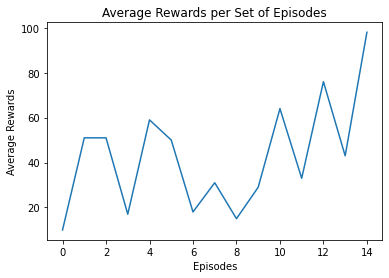

In [16]:
# Plot the average rewards for each set of episodes
# Plot average rewards
episode_sets = range(15)
plt.plot(episode_sets, avg_rewards)
plt.xlabel("Episodes")
plt.ylabel("Average Rewards")
plt.title("Average Rewards per Set of Episodes")
plt.show()

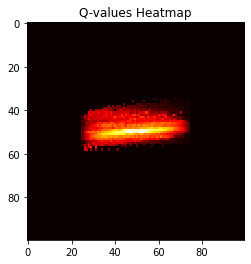

In [17]:
#### Plot Q-values as a heatmap
Q_heatmap = np.max(Q, axis=-1)
plt.imshow(Q_heatmap, cmap='hot', interpolation='nearest')
plt.title("Q-values Heatmap")
plt.show()

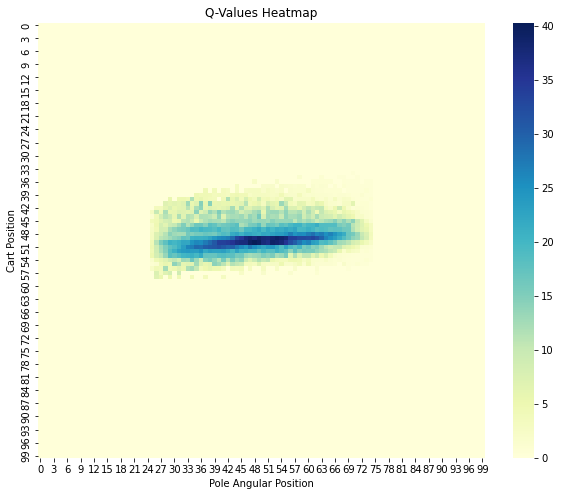

In [18]:
import seaborn as sns

# Create a heatmap for the Q-values matrix
plt.figure(figsize=(10, 8))
sns.heatmap(Q.mean(axis=-1), cmap="YlGnBu")
plt.title("Q-Values Heatmap")
plt.xlabel("Pole Angular Position")
plt.ylabel("Cart Position")
plt.show()
